# Research Question:
## Which socioeconomic factors are accurate predictors for the number of public curbside trees in a NYC neighborhood?

Data Description Draft
Original datasets can be found at the following link: https://cornell.box.com/s/2xiepfs6he94ijg66508tpsd9m2d4nyj 

### Motivation:
The original dataset of trees in New York City was created by the NYC Parks department through its “TreeCount! 2015” initiative. It was funded by the department of parks and recreation, although it was created almost entirely through volunteer work. The dataset was created to track the location, size, species, and condition of all public curbside trees in the city. The first inventory was taken in 1995, and it has been updated each decade since. Having an accurate inventory of trees leads to many benefits for the parks department, including getting funding for street tree pruning and quantifying the ecological and economic benefits of trees. 

A dataset containing demographic information for each zip code was much harder to attain. We ended up using SimplyAnalytics, a  provider of geographic analytics to educational institutions, non-profit organizations, businesses and government agencies. The source of most of SimplyAnalytics' data is the US Census and the American Community Survey which are funded by the government. SimplyAnalytics is a reputable source that is used by many credible universities. 

Our motivation for this project stems from our backgrounds as New York City residents interested in sustainability. We realized that growing up, the presence of nature (specifically trees) was pretty hard to come by in the city, but it was certainly appreciated wherever we could find it. This made us wonder about which neighborhoods had more trees and whether there were common characteristics between those neighborhoods. The benefits of street trees are numerous: they intercept stormwater, remove air pollutants, intake carbon dioxide, improve natural beauty, provide shade, and more. If more trees were planted by the city in a specific neighborhood, the residents of that neighborhood would reap most of the benefits. We suspected that wealthier neighborhoods would have more street trees while poorer neighborhoods would have fewer. This project aims to investigate that claim, as well as other socioeconomic factors that may impact the quantity of street trees such as race.

### Composition: 
Each row in the original dataset represents a single observation of a public curbside tree in New York City. There are 683,788 rows in total which represent all possible instances as every block was covered by the survey. Each row is associated with an identification number which is unique for every tree. The columns in the dataset correspond to various attributes of each tree, either recorded manually or automatically. They include date observed, species, location, diameter, condition, nativity status, and more. 

After cleaning, each row in the zip code dataset represents a single zip code. The columns correspond to different demographic and socioeconomic data categories. There are 180 rows in the dataframe, which are all of the relevant zip codes in New York City. Both datasets are self contained and do not contain any data that may be considered offensive or confidential.
	

### Collection Process:

The data associated with each instance was recorded by one of over 2,200 volunteer citizen mappers as part of the TreeCount! 2015 project. Each volunteer used mapping tools including tape measures, survey wheels, tree identification keys and a web app specifically designed to be used by non-technical users to collect standardized, consistent data. The volunteers came from a variety of backgrounds and neighborhoods across the city, and many of them were part of an existing community group that partnered with the NYC Parks department for this project. They were not paid for their participation. The data was collected between May 2015 and October 2016, and while some years have passed since then, we still believe it to be a representative and relevant indicator of the trees in New York City today.

The zip code data was mainly acquired through the United States Census and American Community Survey. This is mostly self-reported data collected through the surveys. The Census does employ paid workers to help collect responses from households that have not responded to the survey. Individuals that respond consent to the use of the data and understand that their personal data is not used, rather an aggregation of data in their census tract. 

### Preprocessing/Cleaning/Labeling:
The link to the source of the original tree dataset is as follows: https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35 

There was only one modification made directly to the csv file itself. It was found that there were 935 cases of a zipcode of “83” being listed. By looking manually at the addresses for a couple dozen of these cases, it was found that the actual zipcode was always 10029. Therefore all of the 83 values were replaced with 10029 in the csv file before conducting other data cleaning procedures in Jupyter Notebook. 
The zip code data was scraped from incomebyzipcode.com using BeautifulSoup. This gave only income data for each zip code. Once the zip codes were scraped from the website, it became clear that certain zip codes were not relevant to the study as their population was zero. One example of this is the zip code 11371, which is just the LaGuardia airport. In total, 11 zip codes of this type were manually removed from the dataset as this study concerns the demographic statistics of the people living in a zip code, and zip codes with no residents have no demographic data. 
Eventually, we plan to scrape data from unitedstateszipcodes.org which is more reliable and has demographic information that is very relevant to our research question. We had issues web scraping this website for this phase, but Dr. Mimno provided us with techniques to try for the next phase of the project. In the meantime, he told us to choose a sample of 10 representative zip codes from the site and manually input the relevant demographic data.

### Uses:
The New York City tree census data is used by the parks department in order to secure funding and conduct research about the ecological and economic benefits of public curbside trees. Zip code data is broadly used to determine socioeconomic characteristics of a particular neighborhood. In this project, we intend to use the underlying data to investigate our research question for educational purposes. 

### Limitations:
While the New York City street tree census is comprehensive and extensive, it does rely on volunteer data and is thus likely to have some margin of error. Additionally, the census covers only trees on public curbsides, not in parks or private property. While curbside trees are most controllable by public authorities and thus the most likely to be influenced by political factors, they are not the only source of the benefit of trees in the city. The assumption that curbside trees have an effect on quality of life for nearby residents is likely correct, but not the entire story. In terms of the demographic data derived from zip codes, one limitation is that the Census does not receive equal response rates from all neighborhoods and that may affect the margins of error in the data. 


In [1]:
import pandas as pd
import numpy as np
import duckdb, sqlalchemy
import seaborn as sns
from matplotlib import pyplot
import requests
from bs4 import BeautifulSoup
import time
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant as ac

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

In [2]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

In [3]:
NY_tree_census = pd.read_csv('2015StreetTreesCensus.csv')
#https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh
zips = pd.read_csv('nyc_zip_borough_neighborhoods_pop.csv')
#https://data.beta.nyc/en/dataset/pediacities-nyc-neighborhoods/resource/7caac650-d082-4aea-9f9b-3681d568e8a5
zip_analytics = pd.read_csv('zipcode_analytics.csv')

In [4]:
unique_zips = NY_tree_census['zipcode'].unique()
print(unique_zips)
print(len(unique_zips))


#Need to manually remove 77, 89, 155, 181, 191 (no zip code page available) 
#and also zips: 10115, 10020, 10111, 11430, 11371, 11451 (no population)

clean_trees = NY_tree_census[ (NY_tree_census.zipcode != 10048) & (NY_tree_census.zipcode != 11249) & (NY_tree_census.zipcode != 83) & (NY_tree_census.zipcode != 10281) & (NY_tree_census.zipcode != 11251) & (NY_tree_census.zipcode != 10115) & (NY_tree_census.zipcode != 10020) & (NY_tree_census.zipcode != 10111) & (NY_tree_census.zipcode != 11430) & (NY_tree_census.zipcode != 11371) & (NY_tree_census.zipcode != 11451)]

clean_zips = clean_trees['zipcode'].unique()
print(clean_zips)
print(len(clean_zips))

[11375 11357 11211 11215 10023 10019 10305 11223 11105 10308 11205 11212
 11214 11226 11373 10021 10024 10306 11217 11415 11230 10002 11385 10457
 11235 10009 10012 10314 11204 11229 11365 10312 10458 11370 10016 10011
 11231 10025 11372 10467 10453 11209 11358 10027 11203 11355 10115 11210
 10014 11374 11691 11237 11238 11368 11413 11429 10470 11369 10075 11106
 10010 11421 11693 10003 11218 11201 10065 11694 11222 11354 10468 11234
 10036 10017 10038 11232 10048 10026 11101 11219 11412 11361 11364 11432
 11356 10452 11362 11216 11249 10461 11102 11427 11414 11207 11233 11206
 11692 10013 10280 10128 11220 10028 10456 10460 11418 10465 11228 11103
 10309 10466 11377 11221 10463 11225 10022 10001 11434 11426 11224 11236
 10032 10304 10307 11367 11213 11366 10029 10310 10459 11416 11208 11104
 10031 11420 10301 11360 11411 10454 10473 10462 11422 11417 10034 10474
 10018 10303 10037 10069 10040 11435 11363 11004 10471 10033 10035 10472
 10005 10469 11433 10004 11697 10007 10475 11379 10

Zipcodes are extracted from the tree census data set and manually cleaned to remove zip codes that do not exist in online sources or have a population of zero. These rows will be ignored as they will not contribute to our research question of how demographic statistics can predict the number of curbside public trees.

In [22]:
NY_tree_census.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,8/27/15,"180,683","348,711",POINT (-73.84421521958048 40.723091773924274),3,0,OnCurb,Alive,Fair,Acer rubrum,...,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,"1,027,431.15","202,756.77"
1,9/3/15,"200,540","315,986",POINT (-73.81867945834878 40.79411066708779),21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,"1,034,455.70","228,644.84"
2,9/5/15,"204,026","218,365",POINT (-73.93660770459083 40.717580740099116),3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,"1,001,822.83","200,716.89"
3,9/5/15,"204,337","217,969",POINT (-73.93445615919741 40.713537494833226),10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,"1,002,420.36","199,244.25"
4,8/30/15,"189,565","223,043",POINT (-73.97597938483258 40.66677775537875),21,0,OnCurb,Alive,Good,Tilia americana,...,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,"990,913.78","182,202.43"


In [78]:
%sql most_common_trees << SELECT spc_common, COUNT(*) FROM NY_tree_census GROUP BY spc_common ORDER BY COUNT(*) DESC
most_common_trees.head(20)

Returning data to local variable most_common_trees


,spc_common,count_star()
0,London planetree,87014
1,honeylocust,64264
2,Callery pear,58931
3,pin oak,53185
4,Norway maple,34189
5,None,31619
6,littleleaf linden,29742
7,cherry,29279
8,Japanese zelkova,29258
9,ginkgo,21024


In [86]:
%sql clean_tree_zips << SELECT zipcode, COUNT(*) AS TreeCount, AVG(tree_dbh) AS AverageDiameter, \
SUM(case when health = 'Good' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Good, \
SUM(case when health = 'Fair' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Fair, \
SUM(case when health = 'Poor' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Poor, \
SUM(case when status = 'Stump' or status = 'Dead' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Dead, \
SUM(case when spc_common = 'London planetree' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_London_Planetree, \
SUM(case when spc_common = 'honeylocust' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Honeylocust, \
SUM(case when spc_common = 'Callery pear' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Callery_Pear, \
SUM(case when spc_common = 'pin oak' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Pin_Oak, \
SUM(case when spc_common = 'Norway maple' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Norway_Maple, \
SUM(case when spc_common = 'lilttleleaf linden' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Littleleaf_Linden, \
SUM(case when spc_common = 'cherry' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Cherry, \
SUM(case when spc_common = 'Japanese zelkova' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Japanese_Zelkova, \
SUM(case when spc_common = 'ginkgo' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Ginkgo, \
SUM(case when steward = '1or2' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_1or2_stewardship, \
SUM(case when steward = '3or4' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_3or4_stewardship, \
SUM(case when steward = '4orMore' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_4orMore_stewardship, \
SUM(case when steward = 'None' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_No_stewardship, \
SUM(case when guards = 'Helpful' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Helpful_guards, \
SUM(case when guards = 'Harmful' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Harmful_guards, \
SUM(case when guards = 'Unsure' then 1 else 0 end) * 100.0 / COUNT(*) AS Pct_Unsure_guards, \
SUM(case when guards='Helpful' or guards='Harmful' or guards='Unsure' then 0 else 1 end) * 100.0 / COUNT(*) AS Pct_no_guards, \
FROM NY_tree_census \
GROUP BY zipcode ORDER BY zipcode

Returning data to local variable clean_tree_zips


Description: The tree census dataframe is MASSIVE (almost 700k rows, 1 for each tree). The first step is to group by zip codes. The selected fields were the zipcode, total count of recorded trees, and average diameter at breast height (standard measure for tree size). Upon first doing this, it was discovered that there were 935 cases of a zipcode of "83", which is not a valid zipcode. By looking manually at the csv data, it became clear that all of these cases are actually addresses in the 10029 zipcode, so they were manually switched in the csv itself and the code was run again.

In [87]:
clean_tree_zips.head()

,zipcode,TreeCount,AverageDiameter,Pct_Good,Pct_Fair,Pct_Poor,Pct_Dead,Pct_London_Planetree,Pct_Honeylocust,Pct_Callery_Pear,...,Pct_Japanese_Zelkova,Pct_Ginkgo,Pct_1or2_stewardship,Pct_3or4_stewardship,Pct_4orMore_stewardship,Pct_No_stewardship,Pct_Helpful_guards,Pct_Harmful_guards,Pct_Unsure_guards,Pct_no_guards
0,10001,911,7.082327,78.924259,10.976948,3.402854,6.695939,2.305159,28.210757,14.928650,...,8.232711,4.390779,25.356751,8.671789,0.878156,58.397366,19.099890,10.428101,0.219539,70.252470
1,10002,2265,8.237528,73.112583,17.086093,5.077263,4.724062,17.130243,14.304636,7.505519,...,4.547461,8.123620,27.373068,1.633554,0.309051,65.960265,10.551876,3.399558,1.677704,84.370861
2,10003,2025,8.802469,73.086420,17.827160,5.037037,4.049383,6.567901,19.061728,16.000000,...,3.851852,14.962963,42.123457,14.765432,1.086420,37.975309,32.197531,14.172840,3.407407,50.222222
3,10004,118,6.601695,82.203390,14.406780,2.542373,0.847458,6.779661,52.542373,6.779661,...,7.627119,8.474576,64.406780,0.000000,0.000000,34.745763,8.474576,0.000000,0.000000,91.525424
4,10005,144,5.840278,40.972222,39.583333,9.722222,9.722222,0.000000,18.055556,9.027778,...,6.250000,0.000000,29.861111,3.472222,0.000000,56.944444,9.027778,4.166667,0.000000,86.805556


New clean_tree_zips dataframe has all of the tree data we need for future analysis. That is, for each zipcode: number of trees and average tree diameter.

In [88]:
#transpose initial dataframe, create a new index column so zipcodes are their own column
zip_analytics_T=zip_analytics.set_index('Attribute').T.reset_index()

#rename columns
zip_analytics_T.rename(columns={'index': 'zipcode',
                                '# Total Population, 2021 [Estimated]':'population',
                               'Median Household Income, 2021 [Estimated]':'household_income',
                               '% Race | White alone, 2021 [Estimated]':'white_pct',
                               '% Race | Asian alone, 2021 [Estimated]':'asian_pct',
                               '% Race | Black or African American alone, 2021 [Estimated]':'black_pct',
                               '% Race | Some other race alone, 2021 [Estimated]':'other_pct',
                               '% Race | Two or more races, 2021 [Estimated]':'two_or_more_pct',
                               '% Hispanic or Latino | Hispanic or Latino, 2021 [Estimated]':'hispanic_pct',
                               '% Sex | Male, 2021 [Estimated]':'male_pct',
                               '% Sex | Female, 2021 [Estimated]':'female_pct',
                               '% Employment Status | In labor force, 2021 [Estimated]':'employment_pct',
                               '# Housing Units, 2021 [Estimated]':'houses_number',
                               'Healthcare (Household average), 2022':'healthcare_avg'},inplace=True)

#creates three new columns, fills them by splicing existing 'zip' column that has zipcodes and neighborhood 
#assigns borough based on zipcode
zip_analytics_T.insert(loc=1, column='zip',value=0)
zip_analytics_T.insert(loc=2, column='neighborhood',value=0)
zip_analytics_T.insert(loc=3, column='borough',value=0)
for i in range(len(zip_analytics_T['zip'])):
    zipcode = int(zip_analytics_T['zipcode'][i][:5])
    zip_analytics_T['zip'][i]=zipcode
    zip_analytics_T['neighborhood'][i]=zip_analytics_T['zipcode'][i][6:-4]
    if zipcode>10000 and zipcode<10283:
        zip_analytics_T['borough'][i]='Manhattan'
    elif zipcode>10300 and zipcode<10315:
        zip_analytics_T['borough'][i]='Staten Island'
    elif zipcode>10450 and zipcode<10476:
        zip_analytics_T['borough'][i]='Bronx'
    elif (zipcode>11000 and zipcode<11110) or (zipcode>11350 and zipcode<11698):
        zip_analytics_T['borough'][i]='Queens'
    elif zipcode>11200 and zipcode<11257:
        zip_analytics_T['borough'][i]='Brooklyn'
    
zip_analytics_T.drop(columns=['zipcode'],inplace=True)
zip_analytics_T.head()

/var/folders/v2/g3c192bd17n7c5rc2m3s_qxr0000gn/T/ipykernel_86316/3567093898.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_analytics_T['zip'][i]=zipcode
/var/folders/v2/g3c192bd17n7c5rc2m3s_qxr0000gn/T/ipykernel_86316/3567093898.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_analytics_T['neighborhood'][i]=zip_analytics_T['zipcode'][i][6:-4]
/var/folders/v2/g3c192bd17n7c5rc2m3s_qxr0000gn/T/ipykernel_86316/3567093898.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

Attribute,zip,neighborhood,borough,Geographic Unit,white_pct,asian_pct,black_pct,household_income,"# Household Income | Households, 2021 [Estimated]",population,...,"% Transportation to Work | Walked, 2021 [Estimated]",houses_number,"# Housing Tenure | Occupied housing units, 2021 [Estimated]","Healthcare, 2022",healthcare_avg,"# Computers In Household | Households, 2021 [Estimated]","# Total for all sectors | Total Mid-March Employees, 2020","Total for all sectors | Total First Quarter Payroll ($1,000), 2020","Total for all sectors | Total Annual Payroll ($1,000), 2020","# Violent Crime, 2019"
0,11375,Forest Hills,Queens,Zip Code,58.627,29.9964,2.2039,84995.049356309,32927,75049,...,4.6645,35749,32927,255117616.3746,7701.6639,32927,NaN,NaN,NaN,NaN
1,11357,Whitestone,Queens,Zip Code,65.1166,25.3374,0.7162,87759.021679042,14302,39933,...,0.4413,15947,14302,115734112.49995,8031.7924,14302,NaN,NaN,NaN,NaN
2,11211,Brooklyn,Brooklyn,Zip Code,73.0304,5.9829,6.6825,81801.953356303,41759,106353,...,14.0874,45520,41759,377583171.19057,8967.9758,41759,NaN,NaN,NaN,NaN
3,11215,Brooklyn,Brooklyn,Zip Code,77.8047,8.2183,4.4988,133748.58777599,28091,69686,...,8.4216,30345,28091,286720989.713,10130.2309,28091,NaN,NaN,NaN,NaN
4,10023,New York,Manhattan,Zip Code,76.9768,11.1438,5.298,136242.88086007,34849,63892,...,19.236,41667,34849,402643599.31118,11248.5989,34849,NaN,NaN,NaN,NaN


zip_analytics dataframe contains population and demographic data for all NYC zipcodes from Simply Analytics. We first transcribe the dataframe and reset the index so that each zipcode is its own row instead of a column. We then rename the columns. Lastly, we turn the initial zip column into two new columns: zipcode and neighborhood, by splicing text. This can now be combined with our new clean_NY_trees dataframe.

In [89]:
land_area = []
land_area_df = pd.DataFrame()
land_area_df['zips'] = clean_zips

for zip in clean_zips:
    each_zip = requests.get("http://www.usa.com/" + str(zip) + "-ny.htm")
    if each_zip.status_code != 200:
        print("something went wrong:", each_zip.status_code, each_zip.reason)

    with open("1zips.html", "w") as writer:
        writer.write(each_zip.text)
    with open("1zips.html", "r") as reader:
        three_zips = reader.read()
    zip_page = BeautifulSoup(three_zips, "html.parser") 

    all_info = zip_page.findAll('td')

    land_area.append(float(all_info[16].text[0:5]))

land_area_df['land_area'] = land_area
land_area_df.head()


,zips,land_area
0,11375,1.98
1,11357,2.80
2,11211,2.30
3,11215,2.18
4,10023,0.49


In [90]:
%sql final_zips << SELECT * FROM zip_analytics_T, land_area_df WHERE zip_analytics_T.zip=land_area_df.zips ORDER BY zip_analytics_T.zip
final_zips.drop(columns=['zips'],inplace=True) #duplicate zipcode column
final_zips

Returning data to local variable final_zips


,zip,neighborhood,borough,Geographic Unit,white_pct,asian_pct,black_pct,household_income,"# Household Income | Households, 2021 [Estimated]",population,...,houses_number,"# Housing Tenure | Occupied housing units, 2021 [Estimated]","Healthcare, 2022",healthcare_avg,"# Computers In Household | Households, 2021 [Estimated]","# Total for all sectors | Total Mid-March Employees, 2020","Total for all sectors | Total First Quarter Payroll ($1,000), 2020","Total for all sectors | Total Annual Payroll ($1,000), 2020","# Violent Crime, 2019",land_area
0,10001,New York,Manhattan,Zip Code,66.3706,25.8797,2.991,91733.852137359,13548,23872,...,15311,13548,116277624.29507,8224.7656,13548,None,None,None,None,0.62
1,10002,New York,Manhattan,Zip Code,33.8202,40.8048,8.548,37159.062058511,33601,70999,...,35978,33601,249157629.42276,7234.4371,33601,None,None,None,None,0.88
2,10003,New York,Manhattan,Zip Code,74.2913,14.5133,6.4593,118801.11495929,25113,52173,...,30447,25113,258483563.57712,8537.4321,25113,None,None,None,None,0.58
3,10004,New York,Manhattan,Zip Code,55.5175,32.419,4.9564,187819.59766284,1827,3208,...,2293,1827,24646646.93464,13468.1131,1827,None,None,None,None,0.56
4,10005,New York,Manhattan,Zip Code,74.1635,16.8733,0.9545,195127.36631161,4425,9115,...,6139,4425,52505732.55994,11849.635,4425,None,None,None,None,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,11691,Far Rockaway,Queens,Zip Code,37.4177,3.3226,47.0066,49638.391509937,21361,70488,...,22357,21361,148476181.12587,6544.1162,21361,None,None,None,None,2.83
176,11692,Arverne,Queens,Zip Code,19.1663,6.1672,61.4926,46993.695968299,7669,23463,...,8001,7669,50610448.81333,6245.8903,7669,None,None,None,None,1.00
177,11693,Far Rockaway,Queens,Zip Code,65.7293,2.9893,17.6171,61659.95981333,5020,14117,...,5722,5020,34920299.62203,6767.4999,5020,None,None,None,None,1.00
178,11694,Rockaway Park,Queens,Zip Code,82.0338,2.7898,5.7656,84421.8619897,8838,21507,...,9490,8838,69594545.15735,7279.3834,8838,None,None,None,None,1.37


In [99]:
%sql trees_by_zip << SELECT * FROM final_zips, clean_tree_zips WHERE final_zips.zip=clean_tree_zips.zipcode

Returning data to local variable trees_by_zip


Selected all columns from both zips and clean_tree_zips dataframes where the zip codes were the same in both dataframes. Could have used a JOIN statement but this was simpler.

In [100]:
trees_by_zip.drop(columns=['zipcode'],inplace=True) #duplicate zipcode column

In [101]:
trees_by_zip['TreeCount'] = trees_by_zip['TreeCount'].astype(int)
trees_by_zip['population'] = trees_by_zip['population'].astype(int)


trees_by_zip['trees_per_capita']=trees_by_zip['TreeCount']/trees_by_zip['population']
trees_by_zip['trees_per_sq_mile']=trees_by_zip['TreeCount']/trees_by_zip['land_area']
trees_by_zip['trees_per_capita_sq_mile']=100000*trees_by_zip['TreeCount']/trees_by_zip['population']/trees_by_zip['land_area']
trees_by_zip

,zip,neighborhood,borough,Geographic Unit,white_pct,asian_pct,black_pct,household_income,"# Household Income | Households, 2021 [Estimated]",population,"Education | Elementary and high school tuition (Household average), 2022",male_pct,female_pct,other_pct,two_or_more_pct,hispanic_pct,"Education | Elementary and high school tuition, 2022",employment_pct,"% Transportation to Work | Car, truck, or van, 2021 [Estimated]","% Transportation to Work | Walked, 2021 [Estimated]",houses_number,"# Housing Tenure | Occupied housing units, 2021 [Estimated]","Healthcare, 2022",healthcare_avg,"# Computers In Household | Households, 2021 [Estimated]","# Total for all sectors | Total Mid-March Employees, 2020","Total for all sectors | Total First Quarter Payroll ($1,000), 2020","Total for all sectors | Total Annual Payroll ($1,000), 2020","# Violent Crime, 2019",land_area,TreeCount,AverageDiameter,Pct_Good,Pct_Fair,Pct_Poor,Pct_Dead,Pct_London_Planetree,Pct_Honeylocust,Pct_Callery_Pear,Pct_Pin_Oak,Pct_Norway_Maple,Pct_Littleleaf_Linden,Pct_Cherry,Pct_Japanese_Zelkova,Pct_Ginkgo,Pct_1or2_stewardship,Pct_3or4_stewardship,Pct_4orMore_stewardship,Pct_No_stewardship,Pct_Helpful_guards,Pct_Harmful_guards,Pct_Unsure_guards,Pct_no_guards,trees_per_capita,trees_per_sq_mile,trees_per_capita_sq_mile
0,10001,New York,Manhattan,Zip Code,66.3706,25.8797,2.991,91733.852137359,13548,23872,440.8418,50.6325,49.3633,2.304,2.216,14.3976,6232400.42606,72.0773,3.8911,27.9151,15311,13548,116277624.29507,8224.7656,13548,None,None,None,None,0.62,911,7.082327,78.924259,10.976948,3.402854,6.695939,2.305159,28.210757,14.928650,7.025247,0.000000,0.0,0.109769,8.232711,4.390779,25.356751,8.671789,0.878156,58.397366,19.099890,10.428101,0.219539,70.252470,0.038162,1469.354839,6155.139237
1,10002,New York,Manhattan,Zip Code,33.8202,40.8048,8.548,37159.062058511,33601,70999,354.8469,47.1767,52.8219,10.8424,4.4029,26.9187,12221105.11588,52.3058,8.429,25.0631,35978,33601,249157629.42276,7234.4371,33601,None,None,None,None,0.88,2265,8.237528,73.112583,17.086093,5.077263,4.724062,17.130243,14.304636,7.505519,5.121413,0.264901,0.0,3.443709,4.547461,8.123620,27.373068,1.633554,0.309051,65.960265,10.551876,3.399558,1.677704,84.370861,0.031902,2573.863636,3625.211111
2,10003,New York,Manhattan,Zip Code,74.2913,14.5133,6.4593,118801.11495929,25113,52173,456.053,51.9407,48.0555,2.6968,1.6599,9.1158,13807689.31047,65.5912,5.3469,28.9609,30447,25113,258483563.57712,8537.4321,25113,None,None,None,None,0.58,2025,8.802469,73.086420,17.827160,5.037037,4.049383,6.567901,19.061728,16.000000,2.765432,0.197531,0.0,0.444444,3.851852,14.962963,42.123457,14.765432,1.086420,37.975309,32.197531,14.172840,3.407407,50.222222,0.038813,3491.379310,6691.927454
3,10004,New York,Manhattan,Zip Code,55.5175,32.419,4.9564,187819.59766284,1827,3208,500.7645,39.4015,60.5985,1.4651,4.6758,1.2469,916399.08261,80.9173,5.8056,31.5944,2293,1827,24646646.93464,13468.1131,1827,None,None,None,None,0.56,118,6.601695,82.203390,14.406780,2.542373,0.847458,6.779661,52.542373,6.779661,0.000000,0.000000,0.0,0.000000,7.627119,8.474576,64.406780,0.000000,0.000000,34.745763,8.474576,0.000000,0.000000,91.525424,0.036783,210.714286,6568.400428
4,10005,New York,Manhattan,Zip Code,74.1635,16.8733,0.9545,195127.36631161,4425,9115,704.568,45.288,54.701,2.4136,5.5732,6.5387,3121940.61242,92.859,2.0417,30.2872,6139,4425,52505732.55994,11849.635,4425,None,None,None,None,0.07,144,5.840278,40.972222,39.583333,9.722222,9.722222,0.000000,18.055556,9.027778,0.000000,0.000000,0.0,0.000000,6.250000,0.000000,29.861111,3.472222,0.000000,56.944444,9.027778,4.166667,0.000000,86.805556,0.015798,2057.142857,22568.764203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,11691,Far Rockaway,Queens,Zip Code,37.4177,3.3226,47.0066,49638.391509937,21361,70488,338.4796,46.0915,53

In [102]:
borough_dummies = pd.get_dummies(trees_by_zip['borough'],drop_first=True)

double = [trees_by_zip, borough_dummies]
trees_by_zip = pd.concat(double, axis=1)

In [103]:
pd.set_option('display.max_columns', None)
trees_by_zip.head()

,zip,neighborhood,borough,Geographic Unit,white_pct,asian_pct,black_pct,household_income,"# Household Income | Households, 2021 [Estimated]",population,"Education | Elementary and high school tuition (Household average), 2022",male_pct,female_pct,other_pct,two_or_more_pct,hispanic_pct,"Education | Elementary and high school tuition, 2022",employment_pct,"% Transportation to Work | Car, truck, or van, 2021 [Estimated]","% Transportation to Work | Walked, 2021 [Estimated]",houses_number,"# Housing Tenure | Occupied housing units, 2021 [Estimated]","Healthcare, 2022",healthcare_avg,"# Computers In Household | Households, 2021 [Estimated]","# Total for all sectors | Total Mid-March Employees, 2020","Total for all sectors | Total First Quarter Payroll ($1,000), 2020","Total for all sectors | Total Annual Payroll ($1,000), 2020","# Violent Crime, 2019",land_area,TreeCount,AverageDiameter,Pct_Good,Pct_Fair,Pct_Poor,Pct_Dead,Pct_London_Planetree,Pct_Honeylocust,Pct_Callery_Pear,Pct_Pin_Oak,Pct_Norway_Maple,Pct_Littleleaf_Linden,Pct_Cherry,Pct_Japanese_Zelkova,Pct_Ginkgo,Pct_1or2_stewardship,Pct_3or4_stewardship,Pct_4orMore_stewardship,Pct_No_stewardship,Pct_Helpful_guards,Pct_Harmful_guards,Pct_Unsure_guards,Pct_no_guards,trees_per_capita,trees_per_sq_mile,trees_per_capita_sq_mile,Brooklyn,Manhattan,Queens,Staten Island
0,10001,New York,Manhattan,Zip Code,66.3706,25.8797,2.991,91733.852137359,13548,23872,440.8418,50.6325,49.3633,2.304,2.216,14.3976,6232400.42606,72.0773,3.8911,27.9151,15311,13548,116277624.29507,8224.7656,13548,None,None,None,None,0.62,911,7.082327,78.924259,10.976948,3.402854,6.695939,2.305159,28.210757,14.928650,7.025247,0.000000,0.0,0.109769,8.232711,4.390779,25.356751,8.671789,0.878156,58.397366,19.099890,10.428101,0.219539,70.252470,0.038162,1469.354839,6155.139237,0,1,0,0
1,10002,New York,Manhattan,Zip Code,33.8202,40.8048,8.548,37159.062058511,33601,70999,354.8469,47.1767,52.8219,10.8424,4.4029,26.9187,12221105.11588,52.3058,8.429,25.0631,35978,33601,249157629.42276,7234.4371,33601,None,None,None,None,0.88,2265,8.237528,73.112583,17.086093,5.077263,4.724062,17.130243,14.304636,7.505519,5.121413,0.264901,0.0,3.443709,4.547461,8.123620,27.373068,1.633554,0.309051,65.960265,10.551876,3.399558,1.677704,84.370861,0.031902,2573.863636,3625.211111,0,1,0,0
2,10003,New York,Manhattan,Zip Code,74.2913,14.5133,6.4593,118801.11495929,25113,52173,456.053,51.9407,48.0555,2.6968,1.6599,9.1158,13807689.31047,65.5912,5.3469,28.9609,30447,25113,258483563.57712,8537.4321,25113,None,None,None,None,0.58,2025,8.802469,73.086420,17.827160,5.037037,4.049383,6.567901,19.061728,16.000000,2.765432,0.197531,0.0,0.444444,3.851852,14.962963,42.123457,14.765432,1.086420,37.975309,32.197531,14.172840,3.407407,50.222222,0.038813,3491.379310,6691.927454,0,1,0,0
3,10004,New York,Manhattan,Zip Code,55.5175,32.419,4.9564,187819.59766284,1827,3208,500.7645,39.4015,60.5985,1.4651,4.6758,1.2469,916399.08261,80.9173,5.8056,31.5944,2293,1827,24646646.93464,13468.1131,1827,None,None,None,None,0.56,118,6.601695,82.203390,14.406780,2.542373,0.847458,6.779661,52.542373,6.779661,0.000000,0.000000,0.0,0.000000,7.627119,8.474576,64.406780,0.000000,0.000000,34.745763,8.474576,0.000000,0.000000,91.525424,0.036783,210.714286,6568.400428,0,1,0,0
4,10005,New York,Manhattan,Zip Code,74.1635,16.8733,0.9545,195127.36631161,4425,9115,704.568,45.288,54.701,2.4136,5.5732,6.5387,3121940.61242,92.859,2.0417,30.2872,6139,4425,52505732.55994,11849.635,4425,None,None,None,None,0.07,144,5.840278,40.972222,39.583333,9.722222,9.722222,0.000000,18.055556,9.027778,0.000000,0.000000,0.0,0.000000,6.250000,0.000000,29.861111,3.472222,0.000000,56.944444,9.027778,4.166667,0.000000,86.805556,0.015798,2057.142857,22568.764203,0,1,0,0


In [104]:
trees_by_zip = trees_by_zip[['zip', 'borough','household_income', 'white_pct','black_pct', 'asian_pct', 'population', 'Education | Elementary and high school tuition (Household average), 2022', 'male_pct', 'hispanic_pct', 'employment_pct', '% Transportation to Work | Walked, 2021 [Estimated]', 'healthcare_avg', '# Computers In Household | Households, 2021 [Estimated]','land_area', 'TreeCount', 'AverageDiameter', 'trees_per_capita', 'trees_per_sq_mile', 'trees_per_capita_sq_mile', 'Pct_Good','Pct_Fair','Pct_Poor','Pct_Dead','Pct_London_Planetree','Pct_Honeylocust','Pct_Callery_Pear','Pct_Pin_Oak','Pct_Norway_Maple','Pct_Littleleaf_Linden','Pct_Cherry','Pct_Japanese_Zelkova','Pct_Ginkgo','Pct_1or2_stewardship','Pct_3or4_stewardship','Pct_4orMore_stewardship','Pct_No_stewardship','Pct_Helpful_guards','Pct_Harmful_guards','Pct_Unsure_guards','Pct_no_guards','Brooklyn', 'Manhattan', 'Queens', 'Staten Island']].copy()
trees_by_zip.rename(columns={"Education | Elementary and high school tuition (Household average), 2022": "SchoolTuitionAvg", "% Transportation to Work | Walked, 2021 [Estimated]": "walk_to_work_pct", "# Computers In Household | Households, 2021 [Estimated]": "Computers_per_house"}, inplace=True)
trees_by_zip.iloc[:,2:] = trees_by_zip.iloc[:,2:].astype(float)
trees_by_zip['Computers_per_house'] = trees_by_zip['Computers_per_house']/trees_by_zip['population']
trees_by_zip.head()

,zip,borough,household_income,white_pct,black_pct,asian_pct,population,SchoolTuitionAvg,male_pct,hispanic_pct,employment_pct,walk_to_work_pct,healthcare_avg,Computers_per_house,land_area,TreeCount,AverageDiameter,trees_per_capita,trees_per_sq_mile,trees_per_capita_sq_mile,Pct_Good,Pct_Fair,Pct_Poor,Pct_Dead,Pct_London_Planetree,Pct_Honeylocust,Pct_Callery_Pear,Pct_Pin_Oak,Pct_Norway_Maple,Pct_Littleleaf_Linden,Pct_Cherry,Pct_Japanese_Zelkova,Pct_Ginkgo,Pct_1or2_stewardship,Pct_3or4_stewardship,Pct_4orMore_stewardship,Pct_No_stewardship,Pct_Helpful_guards,Pct_Harmful_guards,Pct_Unsure_guards,Pct_no_guards,Brooklyn,Manhattan,Queens,Staten Island
0,10001,Manhattan,91733.852137,66.3706,2.9910,25.8797,23872.0,440.8418,50.6325,14.3976,72.0773,27.9151,8224.7656,0.567527,0.62,911.0,7.082327,0.038162,1469.354839,6155.139237,78.924259,10.976948,3.402854,6.695939,2.305159,28.210757,14.928650,7.025247,0.000000,0.0,0.109769,8.232711,4.390779,25.356751,8.671789,0.878156,58.397366,19.099890,10.428101,0.219539,70.252470,0.0,1.0,0.0,0.0
1,10002,Manhattan,37159.062059,33.8202,8.5480,40.8048,70999.0,354.8469,47.1767,26.9187,52.3058,25.0631,7234.4371,0.473260,0.88,2265.0,8.237528,0.031902,2573.863636,3625.211111,73.112583,17.086093,5.077263,4.724062,17.130243,14.304636,7.505519,5.121413,0.264901,0.0,3.443709,4.547461,8.123620,27.373068,1.633554,0.309051,65.960265,10.551876,3.399558,1.677704,84.370861,0.0,1.0,0.0,0.0
2,10003,Manhattan,118801.114959,74.2913,6.4593,14.5133,52173.0,456.0530,51.9407,9.1158,65.5912,28.9609,8537.4321,0.481341,0.58,2025.0,8.802469,0.038813,3491.379310,6691.927454,73.086420,17.827160,5.037037,4.049383,6.567901,19.061728,16.000000,2.765432,0.197531,0.0,0.444444,3.851852,14.962963,42.123457,14.765432,1.086420,37.975309,32.197531,14.172840,3.407407,50.222222,0.0,1.0,0.0,0.0
3,10004,Manhattan,187819.597663,55.5175,4.9564,32.4190,3208.0,500.7645,39.4015,1.2469,80.9173,31.5944,13468.1131,0.569514,0.56,118.0,6.601695,0.036783,210.714286,6568.400428,82.203390,14.406780,2.542373,0.847458,6.779661,52.542373,6.779661,0.000000,0.000000,0.0,0.000000,7.627119,8.474576,64.406780,0.000000,0.000000,34.745763,8.474576,0.000000,0.000000,91.525424,0.0,1.0,0.0,0.0
4,10005,Manhattan,195127.366312,74.1635,0.9545,16.8733,9115.0,704.5680,45.2880,6.5387,92.8590,30.2872,11849.6350,0.485464,0.07,144.0,5.840278,0.015798,2057.142857,22568.764203,40.972222,39.583333,9.722222,9.722222,0.000000,18.055556,9.027778,0.000000,0.000000,0.0,0.000000,6.250000,0.000000,29.861111,3.472222,0.000000,56.944444,9.027778,4.166667,0.000000,86.805556,0.0,1.0,0.0,0.0


In [105]:
trees_by_zip.to_csv(r'trees_by_zip.csv',index=False)

This is our clean dataset ready for analysis

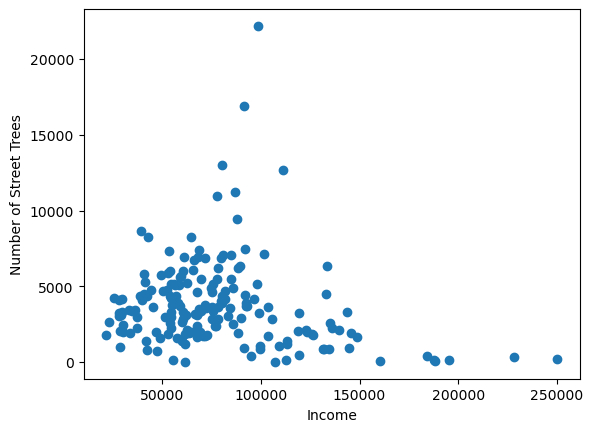

In [170]:
pyplot.xlabel('Income')
pyplot.ylabel('Number of Street Trees')
pyplot.scatter(trees_by_zip['household_income'],trees_by_zip['TreeCount'])


Scatter plot displaying median household income on the x-axis and number of curbside trees on the y-axis. Each data point represents a single zip code. At first glance, it appears as though there may be a positive correlation, although there are a handful of zipcodes with very high income and few trees.

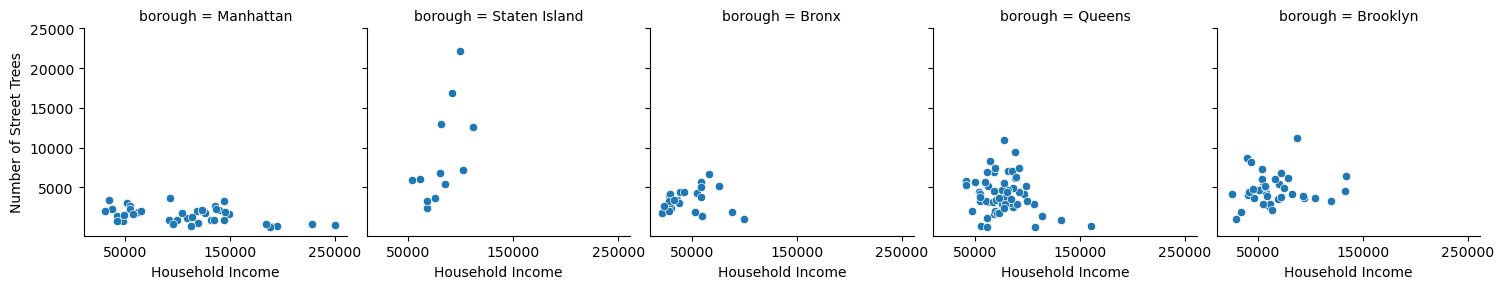

In [171]:
g = sns.FacetGrid(trees_by_zip, col="borough")
g.map(sns.scatterplot, "household_income","TreeCount")
g.set_axis_labels("Household Income", "Number of Street Trees")
g.set(xticks=[50000,150000,250000], yticks=[5000, 10000, 15000, 20000, 25000])

FacetGrid showing the same scatter plot as before, but split up by borough. Manhattan appears to possibly have a negative correlation between household income and number of street trees. Staten Island seems to have a strong positive correlation, while the Bronx, Queens, and Brooklyn appear to have weaker correlations but slightly positive.

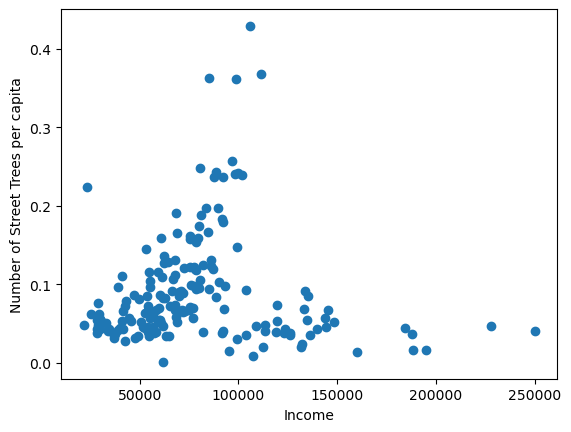

In [172]:
pyplot.xlabel('Income')
pyplot.ylabel('Number of Street Trees per capita')
pyplot.scatter(trees_by_zip['household_income'],trees_by_zip['trees_per_capita'])

When we look at a scatterplot of household income and number of trees per capita, the positive correlation looks slightly stronger. Trees per capita is likely a better than the total number of trees because it accounts for zip codes of different sizes.

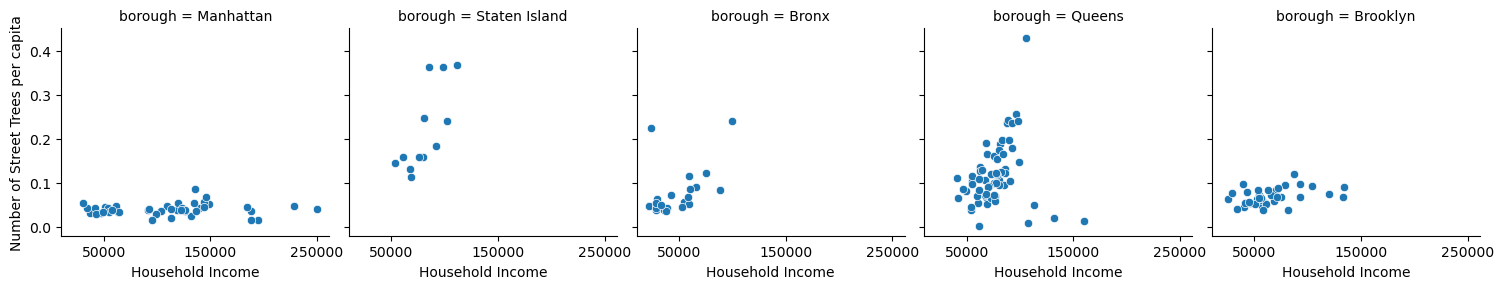

In [173]:
g = sns.FacetGrid(trees_by_zip, col="borough")
g.map(sns.scatterplot, "household_income","trees_per_capita")
g.set_axis_labels("Household Income", "Number of Street Trees per capita")
g.set(xticks=[50000,150000,250000])

With our facet grid now using per-capita trees, the positive correlations look much stronger.

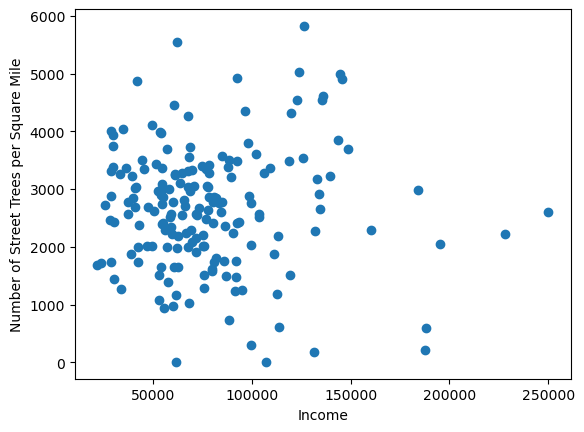

In [174]:
pyplot.xlabel('Income')
pyplot.ylabel('Number of Street Trees per Square Mile')
pyplot.scatter(trees_by_zip['household_income'],trees_by_zip['trees_per_sq_mile'])


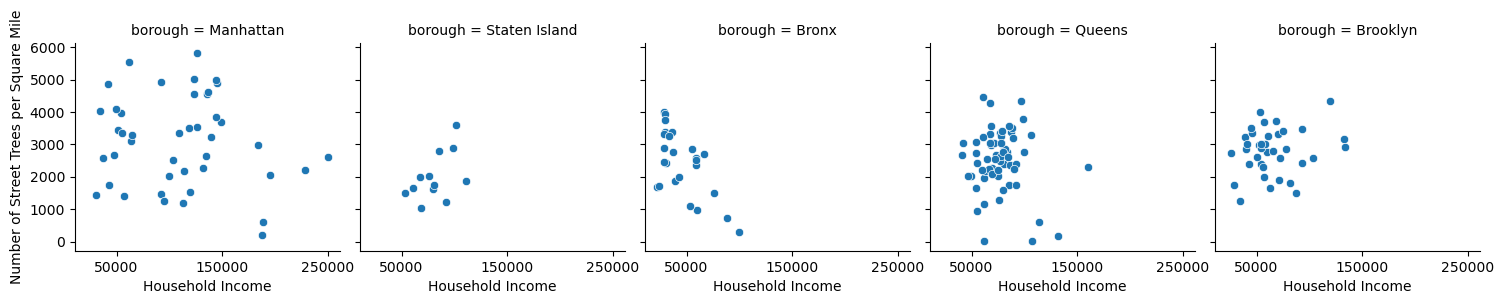

In [175]:
g = sns.FacetGrid(trees_by_zip, col="borough")
g.map(sns.scatterplot, "household_income","trees_per_sq_mile")
g.set_axis_labels("Household Income", "Number of Street Trees per Square Mile")
g.set(xticks=[50000,150000,250000])

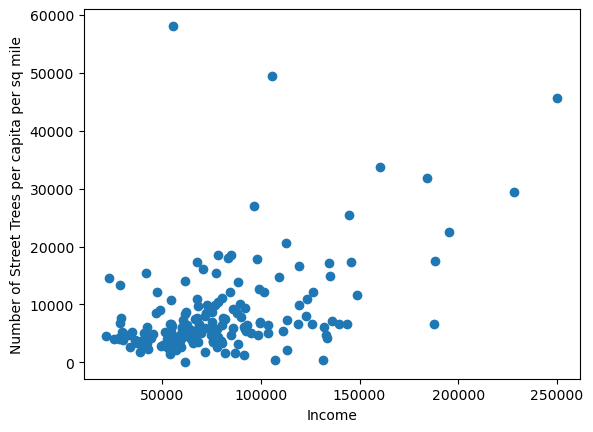

In [176]:
pyplot.xlabel('Income')
pyplot.ylabel('Number of Street Trees per capita per sq mile')
pyplot.scatter(trees_by_zip['household_income'],trees_by_zip['trees_per_capita_sq_mile'])

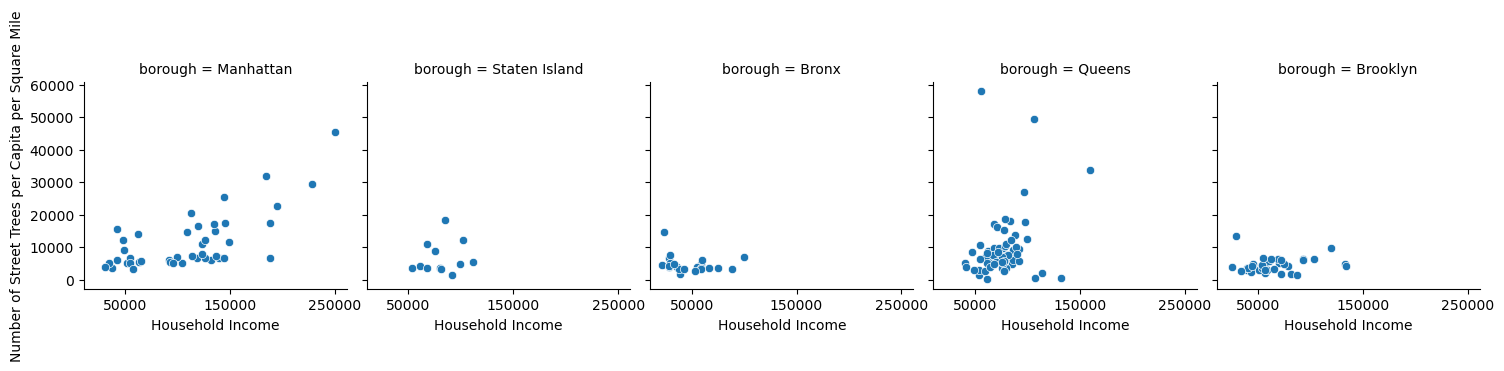

In [177]:
g = sns.FacetGrid(trees_by_zip, col="borough")
g.map(sns.scatterplot, "household_income","trees_per_capita_sq_mile")
g.set_axis_labels("Household Income", "Number of Street Trees per Capita per Square Mile")
g.set(xticks=[50000,150000,250000])

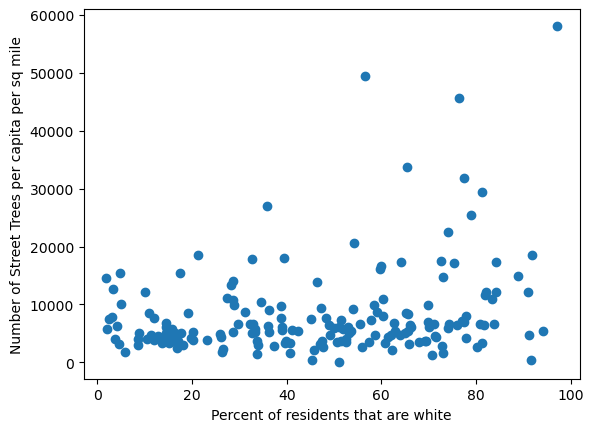

In [178]:
pyplot.xlabel('Percent of residents that are white')
pyplot.ylabel('Number of Street Trees per capita per sq mile')
pyplot.scatter(trees_by_zip['white_pct'],trees_by_zip['trees_per_capita_sq_mile'])

Scatter plot displaying tree count on the y-axis and percentage of the population that is White on the x-axis for the 10 sample zip codes.

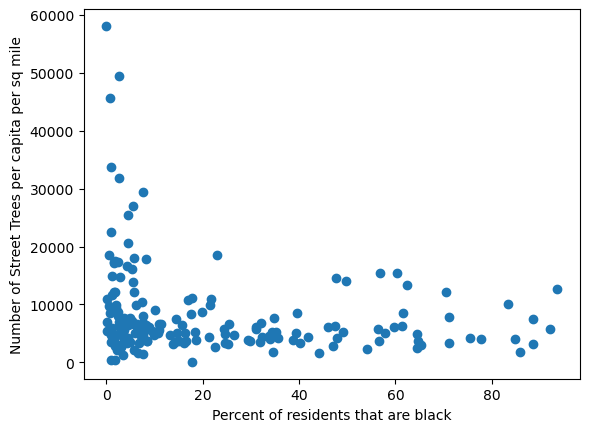

In [179]:
pyplot.xlabel('Percent of residents that are black')
pyplot.ylabel('Number of Street Trees per capita per sq mile')
pyplot.scatter(trees_by_zip['black_pct'],trees_by_zip['trees_per_capita_sq_mile'])

In [180]:
%sql manhattan_trees << SELECT * FROM trees_by_zip WHERE borough='Manhattan'
%sql bronx_trees << SELECT * FROM trees_by_zip WHERE borough='Bronx'
%sql queens_trees << SELECT * FROM trees_by_zip WHERE borough='Queens'
%sql brooklyn_trees << SELECT * FROM trees_by_zip WHERE borough='Brooklyn'
%sql staten_island_trees << SELECT * FROM trees_by_zip WHERE borough='Staten Island'


Returning data to local variable manhattan_trees
Returning data to local variable bronx_trees
Returning data to local variable queens_trees
Returning data to local variable brooklyn_trees
Returning data to local variable staten_island_trees


In [181]:
manhattan_trees[['trees_per_capita_sq_mile','household_income','white_pct','black_pct',
                 'asian_pct','hispanic_pct']].corr()

,trees_per_capita_sq_mile,household_income,white_pct,black_pct,asian_pct,hispanic_pct
trees_per_capita_sq_mile,1.000000,0.690141,0.358084,-0.201777,0.071018,-0.383073
household_income,0.690141,1.000000,0.784778,-0.637104,0.269387,-0.677490
white_pct,0.358084,0.784778,1.000000,-0.844439,0.215678,-0.665151
black_pct,-0.201777,-0.637104,-0.844439,1.000000,-0.459456,0.398645
asian_pct,0.071018,0.269387,0.215678,-0.459456,1.000000,-0.512591
hispanic_pct,-0.383073,-0.677490,-0.665151,0.398645,-0.512591,1.000000


In [182]:
staten_island_trees[['trees_per_capita_sq_mile','household_income','white_pct','black_pct','asian_pct',
                    'hispanic_pct']].corr()

,trees_per_capita_sq_mile,household_income,white_pct,black_pct,asian_pct,hispanic_pct
trees_per_capita_sq_mile,1.000000,0.147795,0.369756,-0.229416,-0.508882,-0.085452
household_income,0.147795,1.000000,0.870759,-0.868131,-0.261835,-0.700873
white_pct,0.369756,0.870759,1.000000,-0.937568,-0.434350,-0.833545
black_pct,-0.229416,-0.868131,-0.937568,1.000000,0.136331,0.849155
asian_pct,-0.508882,-0.261835,-0.434350,0.136331,1.000000,0.106957
hispanic_pct,-0.085452,-0.700873,-0.833545,0.849155,0.106957,1.000000


In [183]:
bronx_trees[['trees_per_capita_sq_mile','household_income','white_pct','black_pct','asian_pct',
                    'hispanic_pct']].corr()

,trees_per_capita_sq_mile,household_income,white_pct,black_pct,asian_pct,hispanic_pct
trees_per_capita_sq_mile,1.000000,-0.220662,-0.211962,0.026876,-0.245148,0.128192
household_income,-0.220662,1.000000,0.847613,-0.363665,0.465936,-0.722456
white_pct,-0.211962,0.847613,1.000000,-0.621515,0.318906,-0.438791
black_pct,0.026876,-0.363665,-0.621515,1.000000,-0.284968,-0.260657
asian_pct,-0.245148,0.465936,0.318906,-0.284968,1.000000,-0.392387
hispanic_pct,0.128192,-0.722456,-0.438791,-0.260657,-0.392387,1.000000


In [184]:
queens_trees[['trees_per_capita_sq_mile','household_income','white_pct','black_pct','asian_pct',
                    'hispanic_pct']].corr()

,trees_per_capita_sq_mile,household_income,white_pct,black_pct,asian_pct,hispanic_pct
trees_per_capita_sq_mile,1.000000,0.253599,0.228783,-0.108272,0.022750,-0.330696
household_income,0.253599,1.000000,0.219134,-0.029299,-0.019914,-0.419310
white_pct,0.228783,0.219134,1.000000,-0.673381,-0.185665,0.048361
black_pct,-0.108272,-0.029299,-0.673381,1.000000,-0.491639,-0.291456
asian_pct,0.022750,-0.019914,-0.185665,-0.491639,1.000000,-0.106848
hispanic_pct,-0.330696,-0.419310,0.048361,-0.291456,-0.106848,1.000000


In [185]:
brooklyn_trees[['trees_per_capita_sq_mile','household_income','white_pct','black_pct','asian_pct',
                    'hispanic_pct']].corr()

,trees_per_capita_sq_mile,household_income,white_pct,black_pct,asian_pct,hispanic_pct
trees_per_capita_sq_mile,1.000000,0.140779,0.063454,0.013220,-0.162758,-0.006974
household_income,0.140779,1.000000,0.516064,-0.335667,-0.019243,-0.283877
white_pct,0.063454,0.516064,1.000000,-0.862643,0.328048,-0.172322
black_pct,0.013220,-0.335667,-0.862643,1.000000,-0.671970,-0.153287
asian_pct,-0.162758,-0.019243,0.328048,-0.671970,1.000000,0.076135
hispanic_pct,-0.006974,-0.283877,-0.172322,-0.153287,0.076135,1.000000


In [186]:
trees_by_zip[['trees_per_capita_sq_mile','household_income','white_pct','black_pct','asian_pct',
                    'hispanic_pct']].corr()

,trees_per_capita_sq_mile,household_income,white_pct,black_pct,asian_pct,hispanic_pct
trees_per_capita_sq_mile,1.000000,0.474642,0.259248,-0.196386,0.121271,-0.291070
household_income,0.474642,1.000000,0.599413,-0.401210,0.146240,-0.561394
white_pct,0.259248,0.599413,1.000000,-0.729557,0.003216,-0.401004
black_pct,-0.196386,-0.401210,-0.729557,1.000000,-0.492103,0.062095
asian_pct,0.121271,0.146240,0.003216,-0.492103,1.000000,-0.273716
hispanic_pct,-0.291070,-0.561394,-0.401004,0.062095,-0.273716,1.000000


In [207]:
%sql summary_stats << SELECT borough,avg(TreeCount)AS 'Mean Tree Total',\
                    avg(trees_per_capita_sq_mile) AS 'Mean Trees per 100,000 residents per square mile',\
                    avg(trees_per_capita) AS 'Mean Trees per capita',\
                    avg(household_income) AS 'Mean Household Income',\
                    avg(white_pct) AS 'Average % White',\
                    avg(black_pct) AS 'Average % Black',\
                    avg(asian_pct) AS 'Average % Asian',\
                    avg(hispanic_pct) AS 'Average % Hispanic' FROM trees_by_zip GROUP BY borough
summary_stats

Returning data to local variable summary_stats


,borough,Mean Tree Total,"Mean Trees per 100,000 residents per square mile",Mean Trees per capita,Mean Household Income,Average % White,Average % Black,Average % Asian,Average % Hispanic
0,Manhattan,1516.581395,11633.717075,0.040004,110218.454136,59.139472,13.217288,14.154347,20.911888
1,Staten Island,8776.500000,6720.783796,0.218984,81193.424921,72.708508,12.046433,8.346408,20.729317
2,Bronx,3408.120000,4781.334431,0.074737,45693.012074,25.621696,34.146096,3.554392,54.148012
3,Queens,3974.063492,9829.031906,0.118267,76723.925145,40.515800,18.162432,24.562392,23.984683
4,Brooklyn,4739.594595,4589.183486,0.068886,65376.421925,45.036365,30.360976,11.781908,18.834830


### Added after submission: 
Find out who plants the trees !! \
**Eventually need to find trees per capita or trees per area or both** \
Clean up the plots + make more + describe them \ 
Clean up the dataframe to only include necessary columns \ 



<AxesSubplot:xlabel='household_income', ylabel='trees_per_capita_sq_mile'>

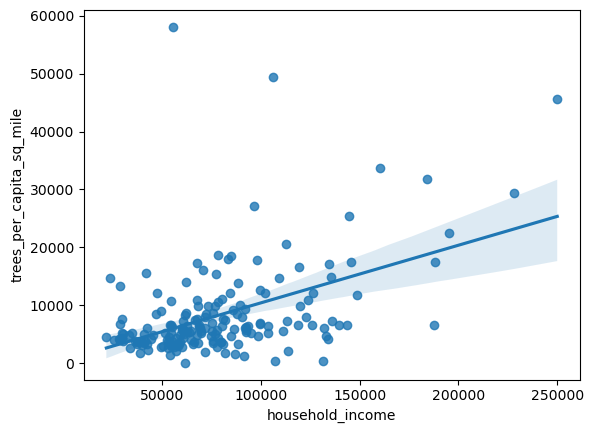

In [188]:
sns.regplot(x=trees_by_zip['household_income'],y=trees_by_zip['trees_per_capita_sq_mile'])

In [189]:
model = LinearRegression().fit(trees_by_zip[['household_income']],trees_by_zip['trees_per_capita_sq_mile'])
model.coef_

array([0.09951268])

In [190]:
linear_model = ols("trees_per_capita_sq_mile ~ household_income", data=trees_by_zip).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     trees_per_capita_sq_mile   R-squared:                       0.225
Model:                                  OLS   Adj. R-squared:                  0.221
Method:                       Least Squares   F-statistic:                     51.76
Date:                      Mon, 21 Nov 2022   Prob (F-statistic):           1.68e-11
Time:                              21:18:38   Log-Likelihood:                -1850.2
No. Observations:                       180   AIC:                             3704.
Df Residuals:                           178   BIC:                             3711.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          474.8851   1205.921      0.394      0.694   -1904.857    2854.627
household_income     0.0995      0.014      7.195      0.000       0.072       0.127
==============================================================================
Omnibus:                      167.172   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3315.747
Skew:                           3.429   Prob(JB):                         0.00
Kurtosis:                      22.877   Cond. No.                     1.99e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [191]:
X = trees_by_zip[['household_income', 'white_pct','black_pct']]
y = trees_by_zip['trees_per_capita_sq_mile']

X = sm.add_constant(X)
multi_model = sm.OLS(y, X).fit()
display(multi_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     trees_per_capita_sq_mile   R-squared:                       0.228
Model:                                  OLS   Adj. R-squared:                  0.214
Method:                       Least Squares   F-statistic:                     17.29
Date:                      Mon, 21 Nov 2022   Prob (F-statistic):           6.93e-10
Time:                              21:18:38   Log-Likelihood:                -1850.0
No. Observations:                       180   AIC:                             3708.
Df Residuals:                           176   BIC:                             3721.
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1587.1729   2094.894      0.758      0.450   -2547.172    5721.518
household_income     0.1051      0.017      6.044      0.000       0.071       0.139
white_pct          -25.4339     34.973     -0.727      0.468     -94.454      43.587
black_pct          -17.9126     32.090     -0.558      0.577     -81.243      45.418
==============================================================================
Omnibus:                      172.145   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3752.320
Skew:                           3.544   Prob(JB):                         0.00
Kurtosis:                      24.215   Cond. No.                     3.44e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

***TA FEEDBACK***\
maybe better to go other way from multi variable to predict one\
put everything in multi-reg model, then exclude correlation\
use borough as an input\
look at date planted of trees, volume\
add more cities (maybe even just one)\
add more y in addition to trees (healthcare?)\
when they were planted ... the trend of NYC planting trees

***TO-DO***
Include more variables ... want to potentially see the largest effect ... use borough as input
Multi Regression
VIF

Add another city ... LA?
Check out trend of trees planted

In [192]:
def run_linear_regression(xTrain, xTest, yTrain, yTest):
    pq = LinearRegression().fit(xTrain, yTrain)
    train_predict = pq.predict(xTrain)
    test_predict = pq.predict(xTest)

    
    print("coefficients:  ")
    print(pq.coef_)
    print("intercept")
    print(pq.intercept_)
    
#     train_acc = metrics.accuracy_score(Ytrain, train_predict)
#     test_acc = metrics.accuracy_score(Ytest, test_predict)
#     print("train accuracy")
#     print(train_acc)
#     print("test accuracy")
#     print(test_acc)

#     train_prec = metrics.precision_score(Ytrain, train_predict)
#     test_prec = metrics.precision_score(Ytest, test_predict)
#     print("train precision")
#     print(train_prec)
#     print("test precision")
#     print(test_prec)
    
#     train_recall = metrics.recall_score(Ytrain, train_predict)
#     test_recall = metrics.recall_score(Ytest, test_predict)
#     print("train recall")
#     print(train_recall)
#     print("test recall")
#     print(test_recall)
    
#     train_f1 = metrics.f1_score(Ytrain, train_predict)
#     test_f1 = metrics.f1_score(Ytest, test_predict)
#     print("train f1")
#     print(train_f1)
#     print("test f1")
#     print(test_f1)

In [197]:
def vif_scores(df):
    VIF_Scores = pd.DataFrame()
    VIF_Scores["Independent Features"] = df.columns
    VIF_Scores["VIF Scores"] = [vif(df.values,i) for i in range(df.shape[1])]
    return VIF_Scores
#using iloc to make sure first two columns (which are strings) aren't included
vif_scores(trees_by_zip.iloc[:,2:])

,Independent Features,VIF Scores
0,household_income,45.606963
1,white_pct,76.242011
2,black_pct,26.571962
3,asian_pct,18.801194
4,population,20.241888
5,SchoolTuitionAvg,54.162751
6,male_pct,283.662739
7,hispanic_pct,19.038223
8,employment_pct,195.112465
9,walk_to_work_pct,7.964788


In [200]:
vif_df_one = trees_by_zip.drop(columns=['zip','borough'])
vif_scores(vif_df_one)

,Independent Features,VIF Scores
0,household_income,45.606963
1,white_pct,76.242011
2,black_pct,26.571962
3,asian_pct,18.801194
4,population,20.241888
5,SchoolTuitionAvg,54.162751
6,male_pct,283.662739
7,hispanic_pct,19.038223
8,employment_pct,195.112465
9,walk_to_work_pct,7.964788


In [201]:
vif_df_two = vif_df_one.drop(columns=['healthcare_avg','male_pct'])
vif_scores(vif_df_two)

,Independent Features,VIF Scores
0,household_income,35.776742
1,white_pct,52.148349
2,black_pct,17.189601
3,asian_pct,12.761553
4,population,20.121660
5,SchoolTuitionAvg,34.168445
6,hispanic_pct,9.515637
7,employment_pct,134.719077
8,walk_to_work_pct,7.419204
9,Computers_per_house,77.237310


In [202]:
vif_df_three = vif_df_two.drop(columns=['population', 'employment_pct', 'land_area', 'TreeCount', 'AverageDiameter', 'trees_per_capita', 'trees_per_sq_mile', 'trees_per_capita_sq_mile'])
vif_scores(vif_df_three)

,Independent Features,VIF Scores
0,household_income,15.163296
1,white_pct,38.810472
2,black_pct,9.818950
3,asian_pct,6.848297
4,SchoolTuitionAvg,29.971789
5,hispanic_pct,2.943141
6,walk_to_work_pct,6.359989
7,Computers_per_house,62.602391
8,Brooklyn,3.781458
9,Manhattan,5.174265


In [203]:
vif_df_four = vif_df_three.drop(columns=['SchoolTuitionAvg', 'Computers_per_house'])
vif_scores(vif_df_four)

,Independent Features,VIF Scores
0,household_income,12.843735
1,white_pct,14.508553
2,black_pct,3.712669
3,asian_pct,4.478195
4,hispanic_pct,2.386918
5,walk_to_work_pct,6.153193
6,Brooklyn,3.589435
7,Manhattan,4.822510
8,Queens,6.033821
9,Staten Island,2.205913


In [205]:
X1 = trees_by_zip[['household_income', 'white_pct','black_pct', 'asian_pct', 'hispanic_pct', 'walk_to_work_pct', 'Brooklyn', 'Manhattan', 'Queens','Staten Island']]
y1 = trees_by_zip[['trees_per_capita_sq_mile']]

DemTrain1, DemTest1, TreeTrain1, TreeTest1 = train_test_split(X1, y1, test_size = 0.2, random_state = 2950)

run_linear_regression(DemTrain1, DemTest1, TreeTrain1, TreeTest1)

coefficients:  
[[ 7.12128220e-02 -3.43661870e+01 -5.84782489e+01 -7.12052575e+01
  -9.71775888e+01 -5.13061788e+01 -3.98301652e+03  1.03649115e+03
   1.30477094e+03 -3.25219683e+03]]
intercept
[9973.57929683]


In [208]:
X1 = sm.add_constant(X1)
multi_model = sm.OLS(y1, X1).fit()
display(multi_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     trees_per_capita_sq_mile   R-squared:                       0.278
Model:                                  OLS   Adj. R-squared:                  0.235
Method:                       Least Squares   F-statistic:                     6.502
Date:                      Mon, 21 Nov 2022   Prob (F-statistic):           1.83e-08
Time:                              21:27:10   Log-Likelihood:                -1843.9
No. Observations:                       180   AIC:                             3710.
Df Residuals:                           169   BIC:                             3745.
Df Model:                                10                                         
Covariance Type:                  nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8721.2147   9481.905      0.920      0.359   -9997.019    2.74e+04
household_income     0.0818      0.022      3.655      0.000       0.038       0.126
white_pct          -31.8611     86.790     -0.367      0.714    -203.193     139.471
black_pct          -50.6576     94.725     -0.535      0.594    -237.655     136.340
asian_pct          -55.6412    107.226     -0.519      0.604    -267.316     156.034
hispanic_pct       -77.0663     70.856     -1.088      0.278    -216.943      62.810
walk_to_work_pct  -109.7624     94.941     -1.156      0.249    -297.185      77.660
Brooklyn         -3426.0562   2238.189     -1.531      0.128   -7844.466     992.353
Manhattan         1277.1563   2364.130      0.540      0.590   -3389.875    5944.187
Queens             769.3157   2196.042      0.350      0.727   -3565.891    5104.522
Staten Island    -3342.8655   3010.734     -1.110      0.268   -9286.357    2600.626
==============================================================================
Omnibus:                      149.235   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2266.824
Skew:                           2.995   Prob(JB):                         0.00
Kurtosis:                      19.321   Cond. No.                     1.58e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [209]:
vif_df_income_drop = vif_df_four.drop(columns=['household_income'])
vif_scores(vif_df_income_drop)

,Independent Features,VIF Scores
0,white_pct,8.173681
1,black_pct,2.937531
2,asian_pct,4.198028
3,hispanic_pct,2.194081
4,walk_to_work_pct,5.914555
5,Brooklyn,3.501229
6,Manhattan,4.768295
7,Queens,6.009699
8,Staten Island,2.189009


In [211]:
X2 = trees_by_zip[['white_pct','black_pct', 'asian_pct', 'hispanic_pct', 'walk_to_work_pct', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']]
y2 = trees_by_zip[['trees_per_capita_sq_mile']]

DemTrain2, DemTest2, TreeTrain2, TreeTest2 = train_test_split(X2, y2, test_size = 0.2, random_state = 2950)

run_linear_regression(DemTrain2, DemTest2, TreeTrain2, TreeTest2)

coefficients:  
[[  -36.05277557   -98.14445262  -113.19300667  -176.97519519
     37.34185574 -5299.85834942  1408.04372935  1377.31338014
  -3617.00779373]]
intercept
[18680.06279086]


In [212]:
X2 = sm.add_constant(X2)
multi_model = sm.OLS(y2, X2).fit()
display(multi_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     trees_per_capita_sq_mile   R-squared:                       0.221
Model:                                  OLS   Adj. R-squared:                  0.180
Method:                       Least Squares   F-statistic:                     5.352
Date:                      Mon, 21 Nov 2022   Prob (F-statistic):           1.93e-06
Time:                              21:27:39   Log-Likelihood:                -1850.8
No. Observations:                       180   AIC:                             3722.
Df Residuals:                           170   BIC:                             3753.
Df Model:                                 9                                         
Covariance Type:                  nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              1.83e+04   9437.787      1.939      0.054    -330.580    3.69e+04
white_pct          -22.6652     89.851     -0.252      0.801    -200.032     154.702
black_pct          -90.8152     97.445     -0.932      0.353    -283.173     101.543
asian_pct         -104.4884    110.188     -0.948      0.344    -322.002     113.025
hispanic_pct      -168.9250     68.613     -2.462      0.015    -304.368     -33.482
walk_to_work_pct   -45.9557     96.653     -0.475      0.635    -236.751     144.840
Brooklyn         -5112.3111   2268.302     -2.254      0.025   -9589.978    -634.645
Manhattan         1902.2966   2442.117      0.779      0.437   -2918.484    6723.077
Queens             929.0421   2273.995      0.409      0.683   -3559.862    5417.946
Staten Island    -4333.4578   3105.561     -1.395      0.165   -1.05e+04    1796.971
==============================================================================
Omnibus:                      131.650   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1215.552
Skew:                           2.720   Prob(JB):                    1.11e-264
Kurtosis:                      14.510   Cond. No.                     1.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [213]:
vif_df_no_income_drop = vif_df_four.drop(columns=['white_pct'])
vif_scores(vif_df_no_income_drop)

,Independent Features,VIF Scores
0,household_income,7.235773
1,black_pct,2.070517
2,asian_pct,3.748710
3,hispanic_pct,1.976274
4,walk_to_work_pct,5.945538
5,Brooklyn,2.301800
6,Manhattan,4.455587
7,Queens,4.723452
8,Staten Island,1.445300


In [214]:
X3 = trees_by_zip[['household_income','black_pct', 'asian_pct', 'hispanic_pct', 'walk_to_work_pct', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']]
y3 = trees_by_zip[['trees_per_capita_sq_mile']]

DemTrain3, DemTest3, TreeTrain3, TreeTest3 = train_test_split(X3, y3, test_size = 0.2, random_state = 2950)

run_linear_regression(DemTrain3, DemTest3, TreeTrain3, TreeTest3)

coefficients:  
[[ 7.12734557e-02 -2.25102026e+01 -3.26191409e+01 -7.44221084e+01
  -5.43847354e+01 -3.96715472e+03  1.07392802e+03  1.27450326e+03
  -3.54350543e+03]]
intercept
[6475.30620073]


In [215]:
X3 = sm.add_constant(X3)
multi_model = sm.OLS(y3, X3).fit()
display(multi_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     trees_per_capita_sq_mile   R-squared:                       0.277
Model:                                  OLS   Adj. R-squared:                  0.239
Method:                       Least Squares   F-statistic:                     7.246
Date:                      Mon, 21 Nov 2022   Prob (F-statistic):           6.88e-09
Time:                              21:28:06   Log-Likelihood:                -1844.0
No. Observations:                       180   AIC:                             3708.
Df Residuals:                           170   BIC:                             3740.
Df Model:                                 9                                         
Covariance Type:                  nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             5590.5666   4134.461      1.352      0.178   -2570.929    1.38e+04
household_income     0.0816      0.022      3.655      0.000       0.038       0.126
black_pct          -17.7979     30.918     -0.576      0.566     -78.830      43.234
asian_pct          -21.3286     52.413     -0.407      0.685    -124.792      82.135
hispanic_pct       -56.8179     44.365     -1.281      0.202    -144.395      30.759
walk_to_work_pct  -111.9571     94.511     -1.185      0.238    -298.523      74.609
Brooklyn         -3478.5785   2227.920     -1.561      0.120   -7876.530     919.373
Manhattan         1254.9151   2357.332      0.532      0.595   -3398.498    5908.328
Queens             712.3155   2184.964      0.326      0.745   -3600.840    5025.471
Staten Island    -3605.2171   2917.235     -1.236      0.218   -9363.889    2153.455
==============================================================================
Omnibus:                      148.961   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2251.716
Skew:                           2.989   Prob(JB):                         0.00
Kurtosis:                      19.263   Cond. No.                     8.62e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""